# Case Study of Wind Forecasting
Author: Christian Mollière
<br>

## 00. Objective and Strategy
The goal is to predict a 24h power forecast with a resolution of 15 min, given the weather forecast for the next 24h in a resolution of 1h. 
<br>
The following items will be tackled.

- Analyse input data, preprocess it and define inputs and outputs (01. The dataset)
- Define and train a set of modelling techniques (02. Defining a model)
- Discuss results & infer measures to improve model performance (03. Conclusion & Outlook)


## 01. The dataset
We begin by taking a closer look at the data provided.

### Importing the data
Using pandas we can easily read-in the provided data. <br>
I like to use icecream for debug prints. <br>
Furthermore, we can have a look for any data fields which are missing data.

In [1]:
!pip install icecream &> /dev/null

import pandas as pd
from icecream import ic

# import data
inputs = pd.read_parquet("../input/privatewinddataset/weather_forecast.parquet") 
target = pd.read_parquet("../input/privatewinddataset/labels.parquet")

# lets see if have me clean data
if inputs.isnull().values.any():
  print(f"Missing data on {len(inputs[inputs.isnull().values])} targets!")

if target.isnull().values.any():
  print(f"Missing data on {len(target[target.isnull().values])} targets!")

Missing data on 341 targets!


### Cleaning the data

Well, seems like there is a stretch of **missing power data**. But where?

In [2]:
# where is data missing?
target[target.isnull().values]

,power
Date,
2020-06-03 23:45:00,NaN
2020-06-04 00:00:00,NaN
2020-06-04 00:15:00,NaN
2020-06-04 00:30:00,NaN
2020-06-04 00:45:00,NaN
...,...
2020-06-07 13:45:00,NaN
2020-06-07 14:00:00,NaN
2020-06-07 14:15:00,NaN


We are **missing data in June 2020**, which is an area we would be using for model identification.<br> No big issue, we will just **cut it out** for now. Don't worry about the corresponding inputs,<br> we will take care of them when we assembly the final input and output matrices.

In [3]:
# lets cut the missing power targets
target_cleaned = target.drop(target[target.isnull().values].index,axis=0)

# check if its ok now
ic(len(target_cleaned[target_cleaned.isnull().values]))

ic| len(target_cleaned[target_cleaned.isnull().values]): 0


0

Let's check the indexing! <br>
Seems like there is a jump every 24 hours. <br>
I will get rid of that by resetting the index...

In [4]:
# reset indices
inputs = inputs.reset_index(drop=True)

Let's plot the dataset and see if we can see any anomalies.

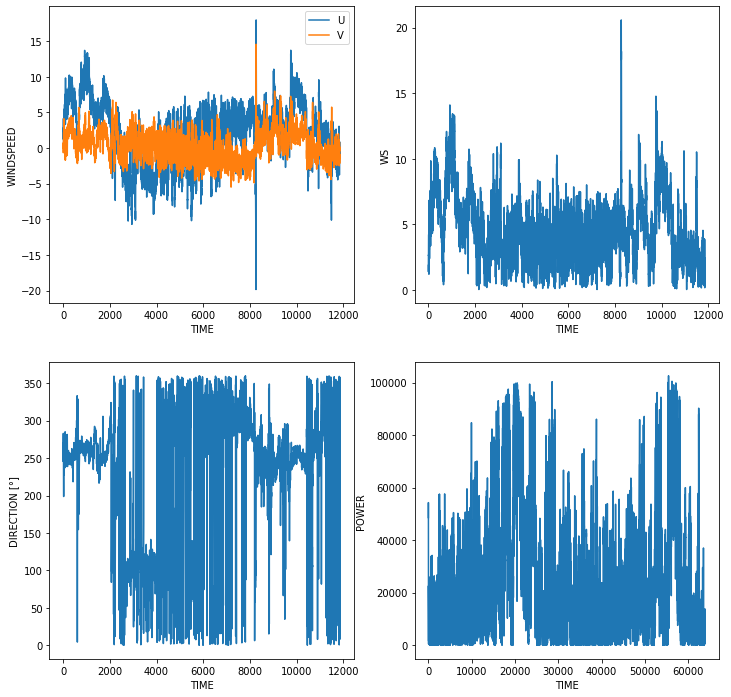

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,12))

# speeds
plt.subplot(221)
plt.plot(inputs.U,label="U")
plt.plot(inputs.V,label="V")
plt.xlabel("TIME")
plt.ylabel("WINDSPEED")
plt.legend()

# magnitude
plt.subplot(222)
plt.plot(inputs.ws,label="WS")
plt.xlabel("TIME")
plt.ylabel("WS")

# direction
plt.subplot(223)
plt.plot(inputs.Direction)
plt.xlabel("TIME")
plt.ylabel("DIRECTION [°]")

# direction
plt.subplot(224)
plt.plot(np.arange(len(target_cleaned)),target_cleaned.power)
plt.xlabel("TIME")
plt.ylabel("POWER")

plt.show()


Okay! Seems like there is some **unusual peak** in the windspeed in the last third of the data.<br>Let's have a closer look on that section.

In [6]:
# where is the outlier?
inputs.Forecast_Date[inputs.ws>15]

8260   2020-06-03 05:00:00
8261   2020-06-03 06:00:00
8262   2020-06-03 07:00:00
8263   2020-06-03 08:00:00
8264   2020-06-03 09:00:00
8265   2020-06-03 10:00:00
8266   2020-06-03 11:00:00
8267   2020-06-03 12:00:00
8268   2020-06-03 13:00:00
8269   2020-06-03 14:00:00
8271   2020-06-03 16:00:00
Name: Forecast_Date, dtype: datetime64[ns]

Great! The outlier is located in the same region as the missing power targets.<br> Maybe the unusually high forecast led to a deactivation of the windturbine. <br> Anyway let's cut this region out as well since it represents an edge case that we do not intend to predict.

In [7]:
# lets cut away the outlier region
cut_start = inputs.index[inputs.ws>15][0] - 10
cut_end   = inputs.index[inputs.ws>15][-1] + 10
inputs_cleaned = inputs.drop(np.arange(cut_start,cut_end+1),axis=0).reset_index(drop=True)

**A short note on detecting outliers:** <br>
If we were to handle very big data sets it would be better to use a sliding window to detect outliers,<br> but in this case a good long stare at the plots should do it.

### Testing for Stationarity
Okay, now since we want to predicit a time series<br> we should have a look if the provided data is **stationary** or not.<br>Lets do that by using an **augmented dickey fulley** test (ADF).

In [8]:
from statsmodels.tsa.stattools import adfuller

def executeADF(data, s=0.05):
  # execute test and gather results
  result = adfuller(data, autolag='AIC')
  adf = pd.Series(result[0:4], index=['statistic','p val','num of Lags','num of observations'])
  for key,value in result[4].items():
      adf[f'critical value ({key})'] = value
  # print results
  print(adf)
  # check if H0 is rejected
  if adf['p val'] <= s:
      print(">> Data is stationary")
  else:
      print(">> Data is non-stationary")

# run test on input and output
for l in ["U","V","ws","Direction"]:
  print(f"\nADF results on {l}:\n----")
  executeADF(inputs_cleaned[l])

print("\nADF results on target:\n----")
executeADF(target_cleaned.power)


ADF results on U:
----
statistic                  -5.427552
p val                       0.000003
num of Lags                40.000000
num of observations     11783.000000
critical value (1%)        -3.430905
critical value (5%)        -2.861785
critical value (10%)       -2.566901
dtype: float64
>> Data is stationary

ADF results on V:
----
statistic              -8.435852e+00
p val                   1.817634e-13
num of Lags             2.900000e+01
num of observations     1.179400e+04
critical value (1%)    -3.430905e+00
critical value (5%)    -2.861785e+00
critical value (10%)   -2.566900e+00
dtype: float64
>> Data is stationary

ADF results on ws:
----
statistic              -6.538490e+00
p val                   9.476241e-09
num of Lags             2.600000e+01
num of observations     1.179700e+04
critical value (1%)    -3.430904e+00
critical value (5%)    -2.861785e+00
critical value (10%)   -2.566900e+00
dtype: float64
>> Data is stationary

ADF results on Direction:
----
statist

Looking good! All data are **stationary** time series.<br><br>

### Normalizing data for training

It might help to normalize the dataset to help the model train better.<br>
We will save the mean and stddev to rescale the output later.<br>

In [9]:
# init mean and stddev
means = {}
stddevs = {}

# normalize inputs
inputs_normalized = inputs_cleaned.copy()
for l in ["U","V","ws","Direction"]:
  means[l]  = np.mean(inputs_cleaned[l])
  stddevs[l] = np.std(inputs_cleaned[l])
  inputs_normalized[l] = (inputs_cleaned[l] - means[l]) / stddevs[l]

# normalize target
target_normalized = target.copy()
means["power"] = np.mean(target_cleaned.power)
stddevs["power"] = np.std(target_cleaned.power)
target_normalized = (target_cleaned - means["power"]) / stddevs["power"]

ic(means)
ic(stddevs)

# define function to rescale power
def rescalePower(y):
  if type(y) == list:
    return [rescalePower(y_) for y_ in y]
  else:
    return stddevs["power"]*y+means["power"]

ic| means: {'Direction': 219.25176954352088,
            'U': 1.9125496973009313,
            'V': 0.374121681554363,
            'power': 23138.99567204681,
            'ws': 4.4742588249522}
ic| stddevs: {'Direction': 89.94795238511402,
              'U': 4.2588379784366825,
              'V': 2.006305450102784,
              'power': 23430.766323716187,
              'ws': 2.4375774511344646}


### Sorting & Splitting
Now as a final step we collect the inputs for every individual target and split<br>the data in training and testing sets.
<br><br>
We already need to decide on what to input in the models to build.<br>
In general, given the dataset, some autoregressive model with external inputs will be suiting.
<br><br>
I suggest modelling by 
- input: the last k power values (including the current at 00:00) and the coming 24 hourly points of wind forecast
- output: the coming 96 points of power forecast

<br>

Let's define a function, that returns different datasets depending on how much power lag (k) we want to use. This will be a hyper parameter to tune later.

In [10]:
from datetime import timedelta

# sort features
def createSequences(inputs, target, k=3):
  # init lists
  X_train, X_test, y_train, y_test = ([] for i in range(4))

  # get all starting times at 00:15:00
  selector = np.logical_and((target_normalized.index.hour == 0),(target_normalized.index.minute == 15))
  starting_times = target_normalized[selector].index
  print(f"Allocating samples for {len(starting_times)} targets")

  # iterate through all possible starts
  for time in starting_times:

    # get last k power targets
    selector = np.logical_and(target_normalized.index >= time - timedelta(minutes=k*15), target_normalized.index < time)
    past_targets = target_normalized[selector].values.reshape(1,-1)
    if(past_targets.shape[1]) != k:
      #print(f"Not enough past targets ({past_targets.shape[1]} of {k}) at {time}!")
      continue

    # get coming 24h of wind forecast
    selector = np.logical_and(inputs_normalized.Forecast_Date > time, inputs_normalized.Forecast_Date <= time + timedelta(hours=24))
    future_inputs = inputs_normalized[selector].drop(["Generation_Date","Forecast_Date"],axis=1).values.reshape(1,-1)
    if(future_inputs.shape[1]) != 96:
      #print(f"Not enough future inputs ({future_inputs.shape[1]} of 96) at {time}!")
      continue

    # get coming 24h of power targets
    selector = np.logical_and(target_normalized.index >= time, target_normalized.index < time + timedelta(hours=24))
    future_targets = target_normalized[selector].values.reshape(1,-1)
    if(future_targets.shape[1]) != 96:
      #print(f"Not enough future targets ({future_targets.shape[1]} of 96) at {time}!")
      continue

    # training or test?
    if time.year == 2020 and time.month in [8,9,10]:
      # test set
      X_test.append(np.squeeze(np.hstack([past_targets,future_inputs])))
      y_test.append(np.squeeze(future_targets))
    else:
      # train set
      X_train.append(np.squeeze(np.hstack([past_targets,future_inputs])))
      y_train.append(np.squeeze(future_targets))

  # show results
  print(f"Finished collecting {len(X_train)+len(X_test)} of {len(starting_times)} samples")

  # return
  return (X_train, X_test, y_train, y_test)
    
# test sequence creation
X_train, X_test, y_train, y_test = createSequences(inputs_normalized, target_normalized)

Allocating samples for 665 targets
Finished collecting 488 of 665 samples


## 02. Defining a model

Considering the <a href="https://ieeexplore.ieee.org/abstract/document/585893/?casa_token=Vd4cascWvywAAAAA:vfOvTWNUYKl4aAxgAUZi3etR1uF4bf0rBErgAc43oxB3VCdOWo6U95TW349AWIIiwnrTmVlFg0w">No Free Lunch Theorem</a> there is no definite best model choice. Instead we can consider different architectures for their up and down sides. In general, while modeling time series data, RNNs might come to mind. Yet, since our input vector can be defined static in length, we don't really need the capability of a RNN to handle sequences of variable lengths. Instead we can unfold the complete series in time and use more light-weight ML techniques, such as SVM regressors, Gradient Boosting or regular MLPs.
<br> <br>
If we were to model short length variable sequence data, I would opt for a GRU network, since it imparts less overhead when compared to LSTMs. If we want to parallelize training of sequential data, we might also try implementing a transformer model.
<br> <br>
As part of this study, I will fit the following models to the training set obtained above.
- A **linear regressor** as a **baseline** model (M1)
- A **decision tree ensemble** using **gradient boosting** (M2)
- A **MLP model** using L2 regularization and dropout (M3)


### Defining the loss function
As defined in the case description a NMAE loss function is implemented.<br><br>
In the following the following terms will be used:
- Total NMAE if the score is calculated for the complete training or test set
- Case-Wise NMAE if the score is calculated for a individual case (i.e. the 96 forecast data points of a sample)

In [11]:
INSTALLED_POWER = 106400

def calcNMAEloss(y,y_pred):
    return 100 * 1/INSTALLED_POWER * np.mean(np.abs(y-y_pred))

### Linear Regression (Baseline) M1
We will use scikit-learn to implement a linear regressor using ordinary least-square (OLS) regression.

Since the OLS has now direct hyperparameters we can only control the model<br>
complexitiy by the number of input parameters. This is done by varying the amount of power lags k.

#### Hyperparameters

In [12]:
# define hyperparameters
params = {"k":[0,3,6,12,24,36,48,60]}

#### Model Identification

In [13]:
from sklearn.linear_model import LinearRegression

# train and test
train_losses = []
test_losses =  []
models = []

for idx, k in enumerate(params["k"]):
  print(f"Training OLS {idx}\n----\n")
  # build sequence
  X_train, X_test, y_train, y_test = createSequences(inputs_normalized, target_normalized, k)
  # fit model
  model = LinearRegression()
  model.fit(X_train, y_train)
  models.append(model)
  # evaluate model
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)
  # print loss
  train_losses.append(calcNMAEloss(rescalePower(y_train), rescalePower(y_pred_train)))
  test_losses.append(calcNMAEloss(rescalePower(y_test), rescalePower(y_pred_test)))
  print(f"Finished OLS for k = {k}, TRAIN loss {train_losses[-1]}, TEST loss {test_losses[-1]}\n\n")

Training OLS 0
----

Allocating samples for 665 targets
Finished collecting 488 of 665 samples
Finished OLS for k = 0, TRAIN loss 6.969249673671089, TEST loss 10.831052306622373


Training OLS 1
----

Allocating samples for 665 targets
Finished collecting 488 of 665 samples
Finished OLS for k = 3, TRAIN loss 6.281463408136581, TEST loss 9.825810543485684


Training OLS 2
----

Allocating samples for 665 targets
Finished collecting 488 of 665 samples
Finished OLS for k = 6, TRAIN loss 6.18209760999622, TEST loss 9.850724316772121


Training OLS 3
----

Allocating samples for 665 targets
Finished collecting 488 of 665 samples
Finished OLS for k = 12, TRAIN loss 6.060663461781976, TEST loss 9.843515953965417


Training OLS 4
----

Allocating samples for 665 targets
Finished collecting 488 of 665 samples
Finished OLS for k = 24, TRAIN loss 5.910350034644037, TEST loss 9.755280565550692


Training OLS 5
----

Allocating samples for 665 targets
Finished collecting 488 of 665 samples
Finished

#### Results

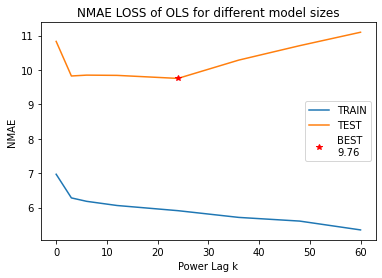

Best achieved TEST NMAE score is 9.755280565550692


In [14]:
# plot losses
plt.figure()
plt.plot(params["k"],train_losses,label="TRAIN")
plt.plot(params["k"],test_losses,label="TEST")
plt.plot(params["k"][np.argmin(test_losses)],np.min(test_losses),'r*',label=f"BEST\n{np.min(test_losses):.2f}")
plt.xlabel("Power Lag k")
plt.ylabel("NMAE")
plt.title("NMAE LOSS of OLS for different model sizes")
plt.legend()
plt.show()

print(f"Best achieved TEST NMAE score is {np.min(test_losses)}")

If we plot the results we see optimal performance around a power lag of k=24 steps. Afterwards the OLS starts to overfit.

----

Lets have a look on some actual results of model (k=24).

Allocating samples for 665 targets
Finished collecting 488 of 665 samples


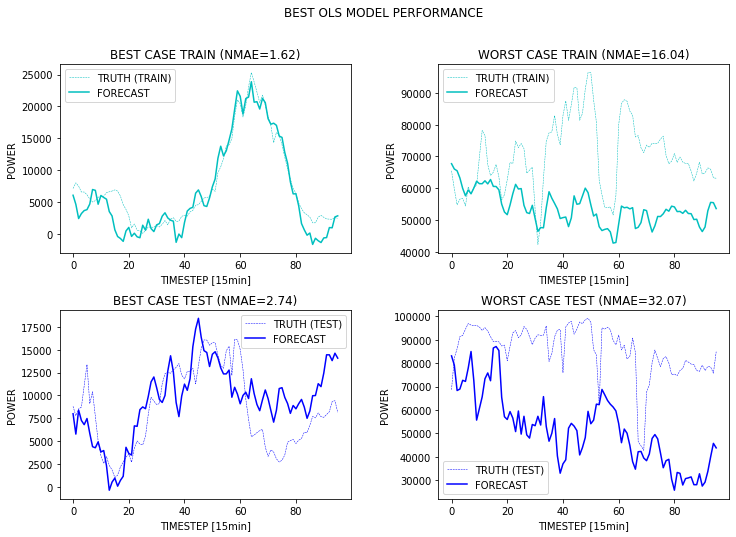

In [15]:
# predict
X_train, X_test, y_train, y_test = createSequences(inputs_normalized, target_normalized, k=24)
y_pred_train, y_pred_test = models[4].predict(X_train), models[4].predict(X_test)

# find best and worst train cases
training_case_losses = [calcNMAEloss(rescalePower(y_),rescalePower(y_p_)) for y_,y_p_ in zip(y_train,y_pred_train)]
training_best_case = np.argmin(training_case_losses)
training_worst_case = np.argmax(training_case_losses)

# find best and worst test cases
test_case_losses = [calcNMAEloss(rescalePower(y_),rescalePower(y_p_)) for y_,y_p_ in zip(y_test,y_pred_test)]
test_best_case = np.argmin(test_case_losses)
test_worst_case = np.argmax(test_case_losses)

# plot cases
plt.figure(figsize=(12,8))

# best training
plt.subplot(221)
plt.plot(rescalePower(y_train[training_best_case]),"c--",lw=0.5,label="TRUTH (TRAIN)")
plt.plot(rescalePower(y_pred_train[training_best_case]),"c-",label="FORECAST")
plt.title(f"BEST CASE TRAIN (NMAE={training_case_losses[training_best_case]:.2f})")
plt.xlabel("TIMESTEP [15min]")
plt.ylabel("POWER")
plt.legend()

# worst training
plt.subplot(222)
plt.plot(rescalePower(y_train[training_worst_case]),"c--",lw=0.5,label="TRUTH (TRAIN)")
plt.plot(rescalePower(y_pred_train[training_worst_case]),"c-",label="FORECAST")
plt.title(f"WORST CASE TRAIN (NMAE={training_case_losses[training_worst_case]:.2f})")
plt.xlabel("TIMESTEP [15min]")
plt.ylabel("POWER")
plt.legend()

# best test
plt.subplot(223)
plt.plot(rescalePower(y_test[test_best_case]),"b--",lw=0.5,label="TRUTH (TEST)")
plt.plot(rescalePower(y_pred_test[test_best_case]),"b-",label="FORECAST")
plt.title(f"BEST CASE TEST (NMAE={test_case_losses[test_best_case]:.2f})")
plt.xlabel("TIMESTEP [15min]")
plt.ylabel("POWER")
plt.legend()

# worst test
plt.subplot(224)
plt.plot(rescalePower(y_test[test_worst_case]),"b--",lw=0.5,label="TRUTH (TEST)")
plt.plot(rescalePower(y_pred_test[test_worst_case]),"b-",label="FORECAST")
plt.title(f"WORST CASE TEST (NMAE={test_case_losses[test_worst_case]:.2f})")
plt.xlabel("TIMESTEP [15min]")
plt.ylabel("POWER")
plt.legend()

plt.suptitle("BEST OLS MODEL PERFORMANCE")
plt.subplots_adjust(hspace=0.3,wspace=0.3)

plt.show()

Not only does the OLS a good job fitting the training data, it is able to generalize on some of the test data as well. Good job for such a simple model.

----

Lets zoom in on the generalization by plotting the histogram's of the NMAE on all data samples predicted.


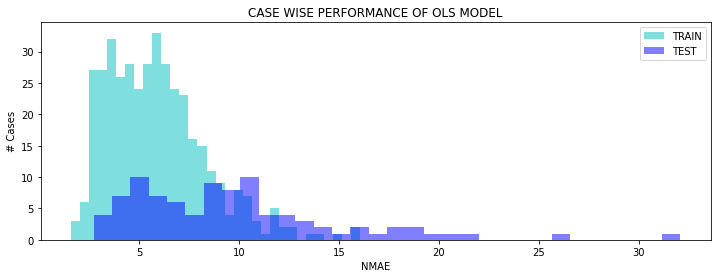

In [16]:
# plot performance on all cases, case-wise
plt.figure(figsize=(12,4))
plt.hist(training_case_losses,bins=32, color="c", alpha=0.5, label="TRAIN")
plt.hist(test_case_losses,bins=32, color="b", alpha=0.5, label="TEST")
plt.xlabel("NMAE")
plt.ylabel("# Cases")
plt.title("CASE WISE PERFORMANCE OF OLS MODEL")
plt.legend()


The majority of training and test case predictions are overlapping in terms of NMAE achieved. Yet, the test data set predicitons are clearly much more spread out on the NMAE side. Some outlier cases are predicted very wrongly.
**The best OLS model (k=24) achieves a total test score of NMAE=9.75.**
<br><br>

----
 

### Decision Tree Ensembles using Gradient Boosting (M2)

The extreme gradient boosting implementation by xgboost enables us to train a ensemble of decision tree regressors by iteratively fitting decision trees on subsets of the training data, while increasing the sampling probability of previously misclassified data points.<br><br>
Since the trees of each iteration are independent of each other they can be trained in parallel to speed up model identification.
<br><br>
**Note:** Because the current implementation of xgb only supports single output gradient boosting we will be using scikit-learn's multioutputregressor to wrap the xgb trees into a singular model.

#### Hyperparameters
First let's define a set of hyperparameters which we will use to perform a random search on. Instead of a MAE loss, the decision trees are fitted using a MSE loss function. This is because XGB needs a loss that is differentiable twice to compute the Hessian of the obtained loss.

In [17]:
# defining the hyperparameter space
param_space = {'objective':'reg:squarederror',
              'colsample_bytree': [0.3,0.7],
              'learning_rate': [0.01,0.3],
              'max_depth': [1,10], 
              'reg_alpha': [0,10],
              'reg_lambda': [0,10],
              'n_estimators': [10,500],
              'subsample': [0.5,1],
              'k' : [0,60],
              #'tree_method': 'gpu_hist',
              }

# lets put a random seed
np.random.seed(42)

# this function will be used to generate a hyper parameter vector within the defined space
def randomParamVector():
  # create random hyperparameter vector
  params = {}
  for key in param_space:
    val = param_space[key]
    if type(val) == list:
      if type(val[0]) == int:
        # randint
        if key == "k":
          k = int(np.round(np.random.rand()*(val[1]-val[0]) + val[0]))
        else:
          params[key] = int(np.round(np.random.rand()*(val[1]-val[0]) + val[0]))
      else:
        # randfloat
        params[key] = np.round(np.random.rand()*(val[1]-val[0]) + val[0],3)
    else:
      # single param
      params[key] = val
  return params, k


#### Model Identification

Now we can build the models by sampling from these parameters.
Random Search will statistically sample a more diverse subset of hyperparameters when <a href="https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf">compared to grid search</a>.
<br><br>
We will built a 100 models given random hyperparameter vectors sampled from the
previously defined hyperparameter space.

In [18]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

# how many points to sample?
n_models = 100

# prepare metrics logs
train_losses, test_losses, xgb_params, xgb_models = ([] for _ in range(4))

for n in range(n_models):
  # sample hyperparameter vector
  params, k = randomParamVector()
  xgb_params.append([params,k])

  # info
  print(f"Training XGB model {n}\n----\n")

  # get datasets
  X_train, X_test, y_train, y_test = createSequences(inputs_normalized, target_normalized, k)
  print(params,k)

  # fit model
  model = MultiOutputRegressor(xgb.XGBRegressor(**params)).fit(X_train, y_train)
  xgb_models.append(model)

  # evaluate model
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # print loss
  train_losses.append(calcNMAEloss(rescalePower(y_train), rescalePower(y_pred_train)))
  test_losses.append(calcNMAEloss(rescalePower(y_test), rescalePower(y_pred_test)))
  print(f"Finished XGB for k = {k}, TRAIN loss {train_losses[-1]:.2f}, TEST loss {test_losses[-1]:.2f}\n\n")

Training XGB model 0
----

Allocating samples for 665 targets
Finished collecting 487 of 665 samples
{'objective': 'reg:squarederror', 'colsample_bytree': 0.45, 'learning_rate': 0.286, 'max_depth': 8, 'reg_alpha': 6, 'reg_lambda': 2, 'n_estimators': 86, 'subsample': 0.529} 52
Finished XGB for k = 52, TRAIN loss 3.55, TEST loss 7.91


Training XGB model 1
----

Allocating samples for 665 targets
Finished collecting 488 of 665 samples
{'objective': 'reg:squarederror', 'colsample_bytree': 0.54, 'learning_rate': 0.215, 'max_depth': 1, 'reg_alpha': 10, 'reg_lambda': 8, 'n_estimators': 114, 'subsample': 0.591} 11
Finished XGB for k = 11, TRAIN loss 6.51, TEST loss 7.49


Training XGB model 2
----

Allocating samples for 665 targets
Finished collecting 488 of 665 samples
{'objective': 'reg:squarederror', 'colsample_bytree': 0.422, 'learning_rate': 0.162, 'max_depth': 5, 'reg_alpha': 3, 'reg_lambda': 6, 'n_estimators': 78, 'subsample': 0.646} 22
Finished XGB for k = 22, TRAIN loss 2.89, TEST l

---- 

#### Results

Now let's also have a look how the models behave given different hyperparameter values in regard to overfitting and overall performance.<br>
An array of scatter plots is presented showing the 100 XGB models colored by different hyperparameter values.

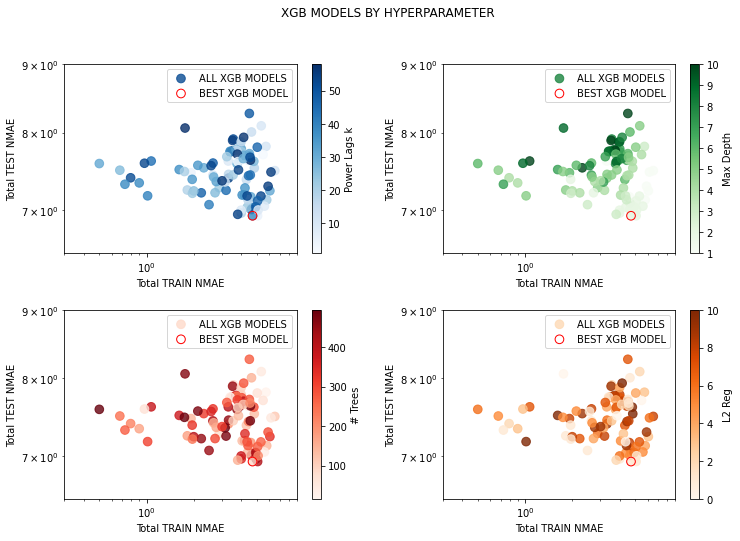

In [19]:
from matplotlib.colors import Normalize

# plot scatter loss
plt.figure(figsize=(12,8))
idx_best = np.argmin(test_losses)

# plot scatter by power lag
plt.subplot(221)
c = [k for p,k in xgb_params]
cmap = "Blues"
plt.scatter(train_losses,test_losses,
            c=c/np.max(c),
            cmap=cmap,marker="o",s=75,label="ALL XGB MODELS",alpha=0.8)
plt.scatter(train_losses[idx_best],test_losses[idx_best],s=75, facecolor="none", color="r",label="BEST XGB MODEL")
plt.xlabel("Total TRAIN NMAE")
plt.ylabel("Total TEST NMAE")
plt.xscale("log")
plt.yscale("log")
plt.xlim([3e-1,9e0])
plt.ylim([6.5e0,9e0])
plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=np.min(c), vmax=np.max(c), clip=False), cmap='Blues'), label="Power Lags k")
plt.legend()

# plot scatter by tree depth
plt.subplot(222)
c = [p["max_depth"] for p,k in xgb_params]
cmap = "Greens"
plt.scatter(train_losses,test_losses,
            c=c/np.max(c),
            cmap=cmap,marker="o",s=75,label="ALL XGB MODELS",alpha=0.8)
plt.scatter(train_losses[idx_best],test_losses[idx_best],s=75, facecolor="none", color="r",label="BEST XGB MODEL")
plt.xlabel("Total TRAIN NMAE")
plt.ylabel("Total TEST NMAE")
plt.xscale("log")
plt.yscale("log")
plt.xlim([3e-1,9e0])
plt.ylim([6.5e0,9e0])
plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=np.min(c), vmax=np.max(c), clip=False), cmap=cmap), label="Max Depth")
plt.legend()

# plot scatter by tree depth
plt.subplot(223)
c = [p["n_estimators"] for p,k in xgb_params]
cmap = "Reds"
plt.scatter(train_losses,test_losses,
            c=c/np.max(c),
            cmap=cmap,marker="o",s=75,label="ALL XGB MODELS",alpha=0.8)
plt.scatter(train_losses[idx_best],test_losses[idx_best],s=75, facecolor="none", color="r",label="BEST XGB MODEL")
plt.xlabel("Total TRAIN NMAE")
plt.ylabel("Total TEST NMAE")
plt.xscale("log")
plt.yscale("log")
plt.xlim([3e-1,9e0])
plt.ylim([6.5e0,9e0])
plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=np.min(c), vmax=np.max(c), clip=False), cmap=cmap), label="# Trees")
plt.legend()

# plot scatter by tree depth
plt.subplot(224)
c = [p["reg_lambda"] for p,k in xgb_params]
cmap = "Oranges"
plt.scatter(train_losses,test_losses,
            c=c/np.max(c),
            cmap=cmap,marker="o",s=75,label="ALL XGB MODELS",alpha=0.8)
plt.scatter(train_losses[idx_best],test_losses[idx_best],s=75, facecolor="none", color="r",label="BEST XGB MODEL")
plt.xlabel("Total TRAIN NMAE")
plt.ylabel("Total TEST NMAE")
plt.xscale("log")
plt.yscale("log")
plt.xlim([3e-1,9e0])
plt.ylim([6.5e0,9e0])
plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=np.min(c), vmax=np.max(c), clip=False), cmap=cmap), label="L2 Reg")
plt.legend()

plt.subplots_adjust(wspace=0.3,hspace=0.3)
plt.suptitle("XGB MODELS BY HYPERPARAMETER")

plt.show()



Seems like shallow decision trees are performing better than deeper trees in general (see upper right scatter plot, green). Regularization (orange), the number of trees per ensemble (red) and the number of power lags (blue) seems to have less obvious effects on the model's performance.

----

Now, lets pick the best XGB model obtained.

In [20]:
idx_best = np.argmin(test_losses)

# print best model
print("BEST XGB MODEL\n----\n")
print(f"Power Lag k = {xgb_params[idx_best][1]}")
for key in xgb_params[idx_best][0]:
  print(f"{key} = {xgb_params[idx_best][0][key]}")
print(f"Total TRAIN NMAE {train_losses[idx_best]:.2f}")
print(f"Total TEST NMAE  {test_losses[idx_best]:.2f}")

BEST XGB MODEL
----

Power Lag k = 38
objective = reg:squarederror
colsample_bytree = 0.553
learning_rate = 0.08
max_depth = 2
reg_alpha = 1
reg_lambda = 1
n_estimators = 84
subsample = 0.569
Total TRAIN NMAE 4.70
Total TEST NMAE  6.93


The best XGB model is very shallow and used around 350 individual decision trees per output feature. A total NMAE of 3.98 and 6.92 on the training and test data set is achieved.

----

As for the OLS model, we take the best model and look at the edge cases in the dataset, plotting the best and worst forecasts on both training and test data.

Allocating samples for 665 targets
Finished collecting 487 of 665 samples


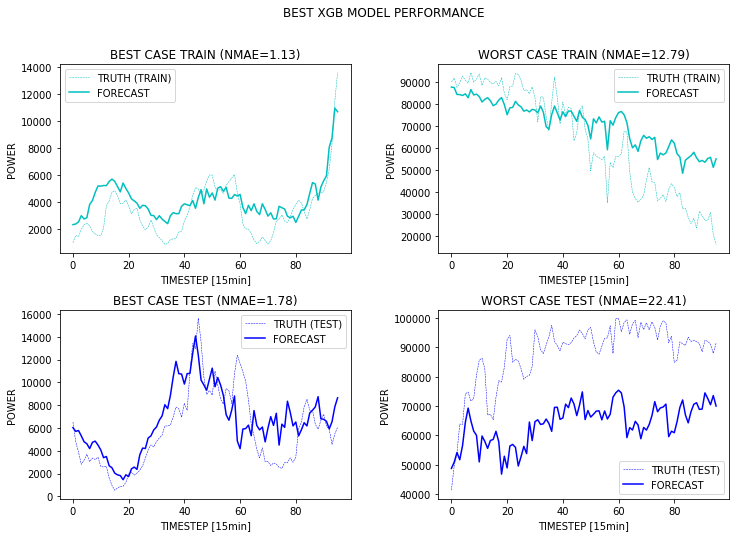

In [21]:
# get best
idx_best = np.argmin(test_losses)
k_best = xgb_params[idx_best][1]
xgb_best = xgb_models[idx_best]

# get dataset
X_train, X_test, y_train, y_test = createSequences(inputs_normalized, target_normalized, k_best)

# predict
y_pred_train, y_pred_test = xgb_best.predict(X_train), xgb_best.predict(X_test)

# find best and worst train cases
training_case_losses = [calcNMAEloss(rescalePower(y_),rescalePower(y_p_)) for y_,y_p_ in zip(y_train,y_pred_train)]
training_best_case = np.argmin(training_case_losses)
training_worst_case = np.argmax(training_case_losses)

# find best and worst test cases
test_case_losses = [calcNMAEloss(rescalePower(y_),rescalePower(y_p_)) for y_,y_p_ in zip(y_test,y_pred_test)]
test_best_case = np.argmin(test_case_losses)
test_worst_case = np.argmax(test_case_losses)

# plot cases
plt.figure(figsize=(12,8))

# best training
plt.subplot(221)
plt.plot(rescalePower(y_train[training_best_case]),"c--",lw=0.5,label="TRUTH (TRAIN)")
plt.plot(rescalePower(y_pred_train[training_best_case]),"c-",label="FORECAST")
plt.title(f"BEST CASE TRAIN (NMAE={training_case_losses[training_best_case]:.2f})")
plt.xlabel("TIMESTEP [15min]")
plt.ylabel("POWER")
plt.legend()

# worst training
plt.subplot(222)
plt.plot(rescalePower(y_train[training_worst_case]),"c--",lw=0.5,label="TRUTH (TRAIN)")
plt.plot(rescalePower(y_pred_train[training_worst_case]),"c-",label="FORECAST")
plt.title(f"WORST CASE TRAIN (NMAE={training_case_losses[training_worst_case]:.2f})")
plt.xlabel("TIMESTEP [15min]")
plt.ylabel("POWER")
plt.legend()

# best test
plt.subplot(223)
plt.plot(rescalePower(y_test[test_best_case]),"b--",lw=0.5,label="TRUTH (TEST)")
plt.plot(rescalePower(y_pred_test[test_best_case]),"b-",label="FORECAST")
plt.title(f"BEST CASE TEST (NMAE={test_case_losses[test_best_case]:.2f})")
plt.xlabel("TIMESTEP [15min]")
plt.ylabel("POWER")
plt.legend()

# worst test
plt.subplot(224)
plt.plot(rescalePower(y_test[test_worst_case]),"b--",lw=0.5,label="TRUTH (TEST)")
plt.plot(rescalePower(y_pred_test[test_worst_case]),"b-",label="FORECAST")
plt.title(f"WORST CASE TEST (NMAE={test_case_losses[test_worst_case]:.2f})")
plt.xlabel("TIMESTEP [15min]")
plt.ylabel("POWER")
plt.legend()

plt.suptitle("BEST XGB MODEL PERFORMANCE")
plt.subplots_adjust(hspace=0.3,wspace=0.3)

plt.show()

The XGB model fits the training data quite well, as indicated by the low total NMAE score on the training data. Still, the XGB model shows good generalization on the test data excluding some of the harder cases.

----

We can make this more visible when inspecting the histograms of all training and test samples predicted.

Text(0.5, 0.98, 'CASE-WISE PERFORMANCES OF BEST XGB MODEL')

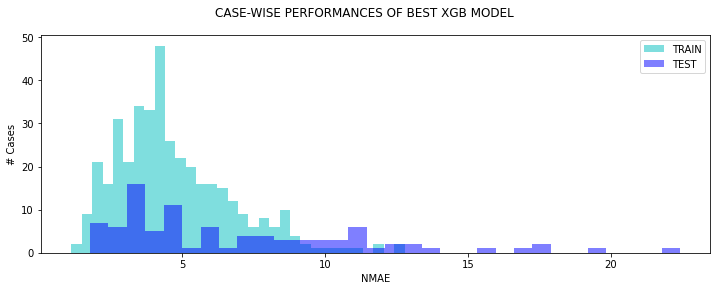

In [22]:
# plot performance on all cases, case-wise
plt.figure(figsize=(12,4))
plt.hist(training_case_losses,bins=32, color="c", alpha=0.5, label="TRAIN")
plt.hist(test_case_losses,bins=32, color="b", alpha=0.5, label="TEST")
plt.xlabel("NMAE")
plt.ylabel("# Cases")
plt.legend()
plt.suptitle("CASE-WISE PERFORMANCES OF BEST XGB MODEL")

The XBG model pushes both, the training and test case distribution towards smaller NMAE, with the majority of training and test cases overlapping.
**The best XGB model achieves a total TEST NMAE of 6.92.**

----

### Multi-Layer Perceptron (M3)

As a third model class, a multi-layer perceptron is implemented using PyTorch imparting dropout layers and ReLU non-linear activations.<br>
The Colab GPU resources are utilized to speed up model identification.

#### Hyperparameters
A set of hyperparameters are defined, selected by previous manual experimenting. Training of the MLP seems quite volatile. Using too strong L2 reg or to big batch sizes might lead to the model failing to train at all.

In [23]:
# defining hyperparameters
param_space = {
    "k" : [0,60],
    "hidden_size" : [32,256],
    "hidden_depth": [3,10],
    "lr" : [1e-4,2e-3],
    "reg_lambda" : [0.0,1e-4],
    "dropout" : [0.0,0.2],
    "early_stopping" : 25,
    "epochs" : 500,
    "batch_size" : [1,64]
}

# lets put a random seed
np.random.seed(42)

# this function will be used to generate a hyper parameter vector within the defined space
def randomParamVector():
  # create random hyperparameter vector
  params = {}
  for key in param_space:
    val = param_space[key]
    if type(val) == list:
      if type(val[0]) == int:
        # randint
        if key == "k":
          k = int(np.round(np.random.rand()*(val[1]-val[0]) + val[0]))
        else:
          params[key] = int(np.round(np.random.rand()*(val[1]-val[0]) + val[0]))
      else:
        # randfloat
        if val[1] < 1e-3 or val[0] < 1e-3:
          params[key] = np.round(np.random.rand()*(val[1]-val[0]) + val[0],5)
        else:
          params[key] = np.round(np.random.rand()*(val[1]-val[0]) + val[0],3)
    else:
      # single param
      params[key] = val
  return params, k

### Model Identification

Let's define a model structure for our MLP model using pytorch

In [24]:
import torch
import torch.nn as nn

class MLPRegressor(nn.Module):
  def __init__(self, input_size, output_size, hidden_size=64, depth=5, dropout=0):
        super().__init__()

        self.layer = nn.ModuleList()

        # input layer
        self.layer.append(nn.Linear(input_size, hidden_size))

        # hidden layer with non-linear activations
        for d in range(depth):
          self.layer.append(nn.Linear(hidden_size,hidden_size))
          if dropout:
            self.layer.append(nn.Dropout())
          self.layer.append(nn.ReLU())

        # output layer with linear output
        self.layer.append(nn.Linear(hidden_size, output_size))

  def forward(self, x):
      # define forward pass
      for l in range(len(self.layer)-1):
        x = self.layer[l](x)
      return self.layer[-1](x)

Proceeding, we put the random search, training loop and evaluation together.


In [25]:
# how many models?
n_models = 100

# logging
mlp_losses = []
mlp_params = []
mlp_models = []

# debugging
verbose = False

# start random search
for n in range(n_models):
  # info
  print(f"\nTraining MLP {n}\n---")

  # sample a vector
  params, k = randomParamVector()
  mlp_params.append((params,k))
  print(params, k)

  # set vars
  batch_size = params["batch_size"]
  epochs = params["epochs"]
  early_stopping = params["early_stopping"]

  # init metric logs
  train_losses, test_losses, gradients = ([] for _ in range(3))

  # get the dataset
  X_train, X_test, y_train, y_test = createSequences(inputs_normalized, target_normalized, k)

  # convert data to np for shuffeling
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  # build a model and put it on the gpu
  model = MLPRegressor(input_size=k+24*4, 
                       output_size=96, 
                       hidden_size=params["hidden_size"], 
                       depth=params["hidden_depth"])
  model.to(device="cuda:0")

  # define loss and compile optimizer
  loss = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), 
                               lr=params["lr"], 
                               weight_decay=params["reg_lambda"])

  # set random seed for shuffeling
  np.random.seed(42)

  # start training
  n_batches_per_epoch = int(len(X_train)/batch_size)
  no_improvement_since_epochs = 0
  best_test_loss = 1e10

  # iterate through epochs
  for e in range(epochs):
    # info
    if verbose:
      print(f"\nTraining MLP epoch {e}\n---")

    # shuffle data
    perm = np.random.permutation(X_train.shape[0])
    X_train = X_train[perm, :]
    y_train = y_train[perm, :]

    # iterate through batches
    for b in range(n_batches_per_epoch):
      # take batch
      x_ = torch.tensor(X_train[b*batch_size:(b+1)*batch_size,:],dtype=torch.float).to(device="cuda:0")
      y_ = torch.tensor(y_train[b*batch_size:(b+1)*batch_size,:],dtype=torch.float).to(device="cuda:0")

      # zero grads
      optimizer.zero_grad()

      # calculate forward pass
      y_pred = model(x_)
      train_loss = loss(y_pred, y_)
      train_loss.backward()

      # step
      optimizer.step()

    # evaluate training NMAE
    x_ = torch.tensor(X_train,dtype=torch.float).to(device="cuda:0")
    y_pred = model(x_).cpu().detach().numpy()
    train_losses.append(calcNMAEloss(rescalePower(y_train),rescalePower(y_pred)))

    # evaluate testing NMAE
    x_ = torch.tensor(X_test,dtype=torch.float).to(device="cuda:0")
    y_pred = model(x_).cpu().detach().numpy()
    test_losses.append(calcNMAEloss(rescalePower(y_test),rescalePower(y_pred)))

    # gradient norm
    total_norm=0
    for p in model.parameters():
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    gradients.append(total_norm)

    # epoch info
    if verbose:
      print(f"Finished training epoch, train NMAE {train_losses[-1]:.2f}, test NMAE {test_losses[-1]:.2f}\n\n")

    # check if early stop?
    if test_losses[-1] < best_test_loss:
      no_improvement_since_epochs = 0
      best_test_loss = test_losses[-1]
    else:
      no_improvement_since_epochs += 1
    
    if no_improvement_since_epochs >= early_stopping:
      print("STOPPING EARLY!")
      break
  
  # finished model
  print(f"Finished MLP {n}, train NMAE {train_losses[-1]:.2f}, test NMAE {test_losses[-1]:.2f}\n\n")
  mlp_models.append(model)
  mlp_losses.append((train_losses,test_losses,gradients))



Training MLP 0
---
{'hidden_size': 245, 'hidden_depth': 8, 'lr': 0.00124, 'reg_lambda': 2e-05, 'dropout': 0.0312, 'early_stopping': 25, 'epochs': 500, 'batch_size': 5} 22
Allocating samples for 665 targets
Finished collecting 488 of 665 samples
STOPPING EARLY!
Finished MLP 0, train NMAE 7.93, test NMAE 8.27



Training MLP 1
---
{'hidden_size': 216, 'hidden_depth': 7, 'lr': 0.00052, 'reg_lambda': 0.0, 'dropout': 0.11068, 'early_stopping': 25, 'epochs': 500, 'batch_size': 9} 24
Allocating samples for 665 targets
Finished collecting 488 of 665 samples
STOPPING EARLY!
Finished MLP 1, train NMAE 5.42, test NMAE 7.74



Training MLP 2
---
{'hidden_size': 77, 'hidden_depth': 4, 'lr': 0.00132, 'reg_lambda': 0.0001, 'dropout': 0.17584, 'early_stopping': 25, 'epochs': 500, 'batch_size': 4} 11
Allocating samples for 665 targets
Finished collecting 488 of 665 samples
STOPPING EARLY!
Finished MLP 2, train NMAE 4.85, test NMAE 7.44



Training MLP 3
---
{'hidden_size': 88, 'hidden_depth': 4, 'lr':

#### Results

Lets have a look at the distribution of training and test NMAE in the models generated. We plot 6 different hyperparameters coloring scatter plots of TRAIN vs TEST NMAE to gain insight on important hyperparameters.

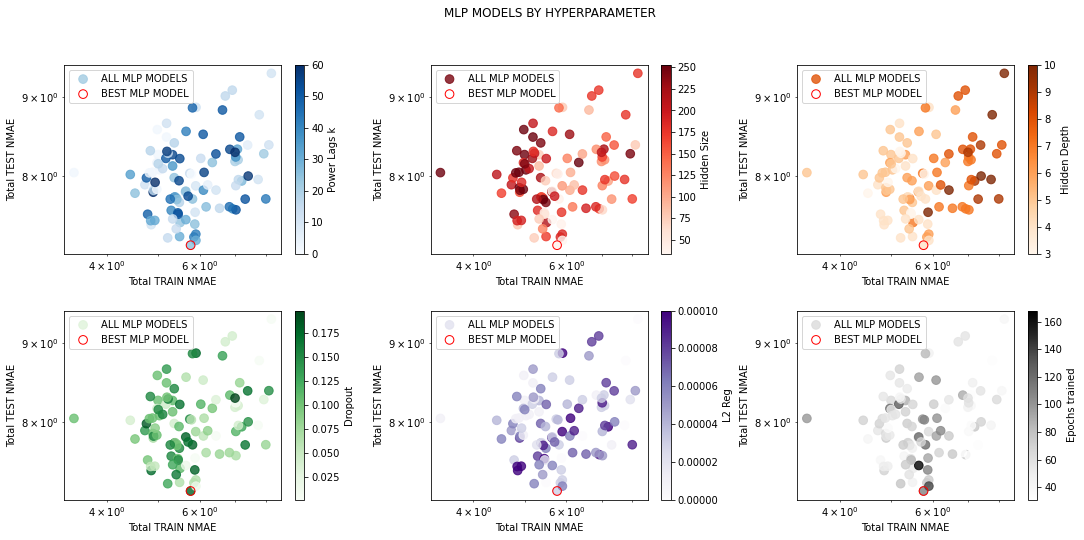

In [26]:
from matplotlib.colors import Normalize

# plot scatter loss
plt.figure(figsize=(18,8))
idx_best = np.argmin([test_losses[-1] for train_losses,test_losses,gradients in mlp_losses])
train_losses = [tr[-1] for tr,te,gr in mlp_losses]
test_losses = [te[-1] for tr,te,gr in mlp_losses]

# plot scatter by power lag
plt.subplot(231)
c = [k for p,k in mlp_params]
cmap = "Blues"
plt.scatter(train_losses,test_losses,
            c=c/np.max(c),
            cmap=cmap,marker="o",s=75,label="ALL MLP MODELS",alpha=0.8)
plt.scatter(train_losses[idx_best],test_losses[idx_best],s=75, facecolor="none", color="r",label="BEST MLP MODEL")
plt.xlabel("Total TRAIN NMAE")
plt.ylabel("Total TEST NMAE")
plt.xscale("log")
plt.yscale("log")
plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=np.min(c), vmax=np.max(c), clip=False), cmap=cmap), label="Power Lags k")
plt.legend()

# plot scatter by hidden size
plt.subplot(232)
c = [p["hidden_size"] for p,k in mlp_params]
cmap = "Reds"
plt.scatter(train_losses,test_losses,
            c=c/np.max(c),
            cmap=cmap,marker="o",s=75,label="ALL MLP MODELS",alpha=0.8)
plt.scatter(train_losses[idx_best],test_losses[idx_best],s=75, facecolor="none", color="r",label="BEST MLP MODEL")
plt.xlabel("Total TRAIN NMAE")
plt.ylabel("Total TEST NMAE")
plt.xscale("log")
plt.yscale("log")
plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=np.min(c), vmax=np.max(c), clip=False), cmap=cmap), label="Hidden Size")
plt.legend()

# plot scatter by hidden depth
plt.subplot(233)
c = [p["hidden_depth"] for p,k in mlp_params]
cmap = "Oranges"
plt.scatter(train_losses,test_losses,
            c=c/np.max(c),
            cmap=cmap,marker="o",s=75,label="ALL MLP MODELS",alpha=0.8)
plt.scatter(train_losses[idx_best],test_losses[idx_best],s=75, facecolor="none", color="r",label="BEST MLP MODEL")
plt.xlabel("Total TRAIN NMAE")
plt.ylabel("Total TEST NMAE")
plt.xscale("log")
plt.yscale("log")
plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=np.min(c), vmax=np.max(c), clip=False), cmap=cmap), label="Hidden Depth")
plt.legend()

# plot scatter by hidden depth
plt.subplot(234)
c = [p["dropout"] for p,k in mlp_params]
cmap = "Greens"
plt.scatter(train_losses,test_losses,
            c=c/np.max(c),
            cmap=cmap,marker="o",s=75,label="ALL MLP MODELS",alpha=0.8)
plt.scatter(train_losses[idx_best],test_losses[idx_best],s=75, facecolor="none", color="r",label="BEST MLP MODEL")
plt.xlabel("Total TRAIN NMAE")
plt.ylabel("Total TEST NMAE")
plt.xscale("log")
plt.yscale("log")
plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=np.min(c), vmax=np.max(c), clip=False), cmap=cmap), label="Dropout")
plt.legend()

# plot scatter by l2 reg
plt.subplot(235)
c = [p["reg_lambda"] for p,k in mlp_params]
cmap = "Purples"
plt.scatter(train_losses,test_losses,
            c=c/np.max(c),
            cmap=cmap,marker="o",s=75,label="ALL MLP MODELS",alpha=0.8)
plt.scatter(train_losses[idx_best],test_losses[idx_best],s=75, facecolor="none", color="r",label="BEST MLP MODEL")
plt.xlabel("Total TRAIN NMAE")
plt.ylabel("Total TEST NMAE")
plt.xscale("log")
plt.yscale("log")
plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=np.min(c), vmax=np.max(c), clip=False), cmap=cmap), label="L2 Reg")
plt.legend()

# plot scatter by training length
plt.subplot(236)
c = [len(tr) for tr,te,gr in mlp_losses]
cmap = "Greys"
plt.scatter(train_losses,test_losses,
            c=c/np.max(c),
            cmap=cmap,marker="o",s=75,label="ALL MLP MODELS",alpha=0.8)
plt.scatter(train_losses[idx_best],test_losses[idx_best],s=75, facecolor="none", color="r",label="BEST MLP MODEL")
plt.xlabel("Total TRAIN NMAE")
plt.ylabel("Total TEST NMAE")
plt.xscale("log")
plt.yscale("log")
plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=np.min(c), vmax=np.max(c), clip=False), cmap=cmap), label="Epochs trained")
plt.legend()


plt.subplots_adjust(wspace=0.35,hspace=0.3)
plt.suptitle("MLP MODELS BY HYPERPARAMETER")

plt.show()

Seems like shallow MLP (small hidden depth, orange) containing small layer sizes (small hidden size, red) perform the best in general. The amount of power lags (k, blue) provided doesn't show a clear correlation with overall performance. Same goes for the L2 reg (purple), dropout (green). Very deep models appear hard to fit even on the training data, where as very big layer sizes tend to overfit.

----

Lets pick the best model obtained and have a closer look at it.

In [27]:
idx_best = np.argmin([test_losses[-1] for train_losses,test_losses,gradients in mlp_losses])

# print best model
print("BEST MLP MODEL\n----\n")
print(f"Power Lag k = {mlp_params[idx_best][1]}")
for key in mlp_params[idx_best][0]:
  print(f"{key} = {mlp_params[idx_best][0][key]}")
print(f"Trained for {len(mlp_losses[idx_best][0])} epochs")
print(f"Total TRAIN NMAE {mlp_losses[idx_best][0][-1]:.2f}")
print(f"Total TEST NMAE  {mlp_losses[idx_best][1][-1]:.2f}")

BEST MLP MODEL
----

Power Lag k = 25
hidden_size = 39
hidden_depth = 4
lr = 0.00071
reg_lambda = 3e-05
dropout = 0.17992
early_stopping = 25
epochs = 500
batch_size = 48
Trained for 110 epochs
Total TRAIN NMAE 5.76
Total TEST NMAE  7.22


The model is trained for only 72 epochs before beeing early-stopped and achieves a NMAE of 5.7 and 7.32 on training and test data respectively.

----

Does it overfit on the training data?

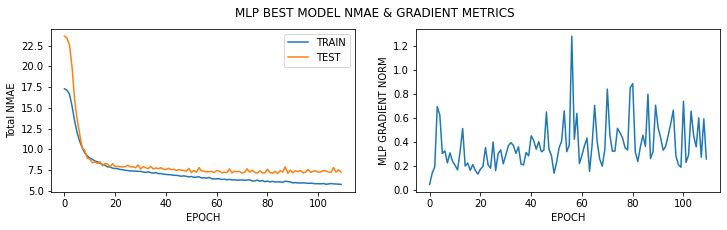

In [28]:
# plot loss per epoch and gradient norm
train_losses, test_losses, gradients = mlp_losses[idx_best]

plt.figure(figsize=(12,3))

plt.subplot(121)
plt.plot(train_losses,label="TRAIN")
plt.plot(test_losses,label="TEST")
plt.xlabel("EPOCH")
plt.ylabel("Total NMAE")
plt.legend()

plt.subplot(122)
plt.plot(gradients)
plt.xlabel("EPOCH")
plt.ylabel("MLP GRADIENT NORM")

plt.suptitle("MLP BEST MODEL NMAE & GRADIENT METRICS")

plt.show()

Training and test loss are seperating over time. Although the test loss does not appear to increase. Therefore, the model is showing slight overfitting without degrading its performance on the test set.

----

As before we have a look on the edge cases (best/worst) train & test sample.

Allocating samples for 665 targets
Finished collecting 488 of 665 samples


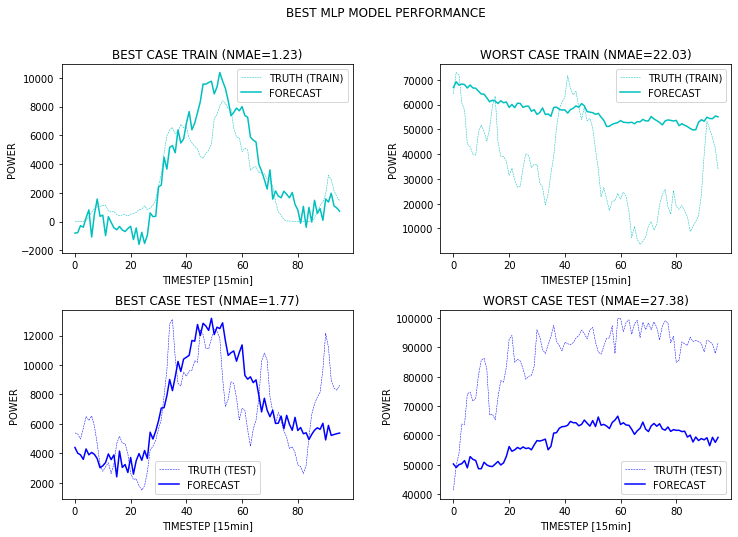

In [29]:
# plot best & worst cases
idx_best = np.argmin([test_losses[-1] for train_losses,test_losses,gradients in mlp_losses])
model = mlp_models[idx_best]
k = mlp_params[idx_best][1]

# get dataset
X_train, X_test, y_train, y_test = createSequences(inputs_normalized, target_normalized, k)

# predict
x_ = torch.tensor(X_train,dtype=torch.float).to(device="cuda:0")
y_pred_train = model(x_).cpu().detach().numpy()
x_ = torch.tensor(X_test,dtype=torch.float).to(device="cuda:0")
y_pred_test = model(x_).cpu().detach().numpy()

# find best and worst train cases
training_case_losses = [calcNMAEloss(rescalePower(y_),rescalePower(y_p_)) for y_,y_p_ in zip(y_train,y_pred_train)]
training_best_case = np.argmin(training_case_losses)
training_worst_case = np.argmax(training_case_losses)

# find best and worst test cases
test_case_losses = [calcNMAEloss(rescalePower(y_),rescalePower(y_p_)) for y_,y_p_ in zip(y_test,y_pred_test)]
test_best_case = np.argmin(test_case_losses)
test_worst_case = np.argmax(test_case_losses)

# plot cases
plt.figure(figsize=(12,8))

# best training
plt.subplot(221)
plt.plot(rescalePower(y_train[training_best_case]),"c--",lw=0.5,label="TRUTH (TRAIN)")
plt.plot(rescalePower(y_pred_train[training_best_case]),"c-",label="FORECAST")
plt.title(f"BEST CASE TRAIN (NMAE={training_case_losses[training_best_case]:.2f})")
plt.xlabel("TIMESTEP [15min]")
plt.ylabel("POWER")
plt.legend()

# worst training
plt.subplot(222)
plt.plot(rescalePower(y_train[training_worst_case]),"c--",lw=0.5,label="TRUTH (TRAIN)")
plt.plot(rescalePower(y_pred_train[training_worst_case]),"c-",label="FORECAST")
plt.title(f"WORST CASE TRAIN (NMAE={training_case_losses[training_worst_case]:.2f})")
plt.xlabel("TIMESTEP [15min]")
plt.ylabel("POWER")
plt.legend()

# best test
plt.subplot(223)
plt.plot(rescalePower(y_test[test_best_case]),"b--",lw=0.5,label="TRUTH (TEST)")
plt.plot(rescalePower(y_pred_test[test_best_case]),"b-",label="FORECAST")
plt.title(f"BEST CASE TEST (NMAE={test_case_losses[test_best_case]:.2f})")
plt.xlabel("TIMESTEP [15min]")
plt.ylabel("POWER")
plt.legend()

# worst test
plt.subplot(224)
plt.plot(rescalePower(y_test[test_worst_case]),"b--",lw=0.5,label="TRUTH (TEST)")
plt.plot(rescalePower(y_pred_test[test_worst_case]),"b-",label="FORECAST")
plt.title(f"WORST CASE TEST (NMAE={test_case_losses[test_worst_case]:.2f})")
plt.xlabel("TIMESTEP [15min]")
plt.ylabel("POWER")
plt.legend()

plt.suptitle("BEST MLP MODEL PERFORMANCE")
plt.subplots_adjust(hspace=0.3,wspace=0.3)

plt.show()

The MLP model seems to generalize quite well, catching the overall trend of almost all samples. Yet, as seen before in the other models some particular hard cases to forecast persist in the dataset.

----

Finally, lets have a look on the histogram of NMAE in the individual cases (samples).

Text(0.5, 0.98, 'CASE-WISE PERFORMANCES OF BEST MLP MODEL')

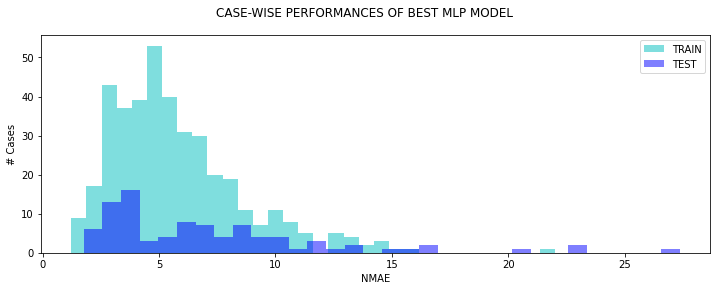

In [30]:
# plot performance on all cases, case-wise
plt.figure(figsize=(12,4))
plt.hist(training_case_losses,bins=32, color="c", alpha=0.5, label="TRAIN")
plt.hist(test_case_losses,bins=32, color="b", alpha=0.5, label="TEST")
plt.xlabel("NMAE")
plt.ylabel("# Cases")
plt.legend()
plt.suptitle("CASE-WISE PERFORMANCES OF BEST MLP MODEL")

As the XGB models before, the MLP models perform better when compared to the baseline linear regressor model. Although having a slightly lower overall train and test NMAE score, the MLP model show the greatest amount of overlap in predicted training and test samples. Thus, it seems to generalize better than the XGB model. **The best MLP achieves a total NMAE test score of around 7.32**.

----


## 03. Conclusion & Outlook

### Conclusion

#### Comparing Mean Performance 

All three models were successful in fitting the provided dataset consistently achieving total test NMAE scores below 10 NMAE. The achieved results are summarized below:

- **OLS** (M1):  Total TRAIN NMAE 5.91, Total TEST NMAE 9.76
- **XGB** (M2):  Total TRAIN NMAE **3.98**, Total Test NMAE **6.92**
- **MLP** (M3): Total TRAIN NMAE 5.70, Total Test NMAE 7.32

The XGB model achieves the best overall performance by NMAE metrics alone.

----

#### Comparing Case-Wise Performance

If we compare the case-wise scores in the histograms, we can have a clearer view if the models show overfitting.

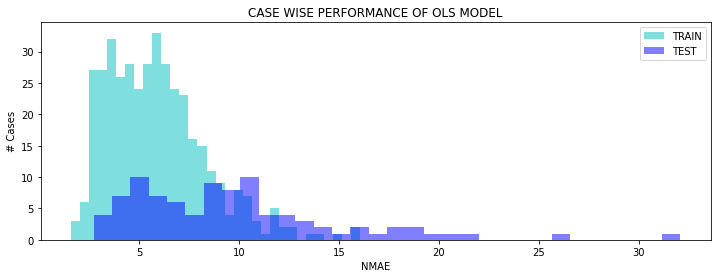
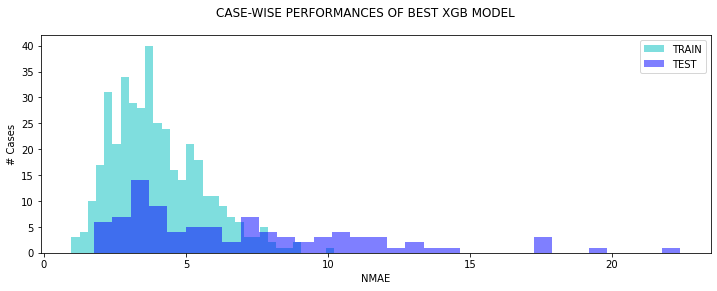
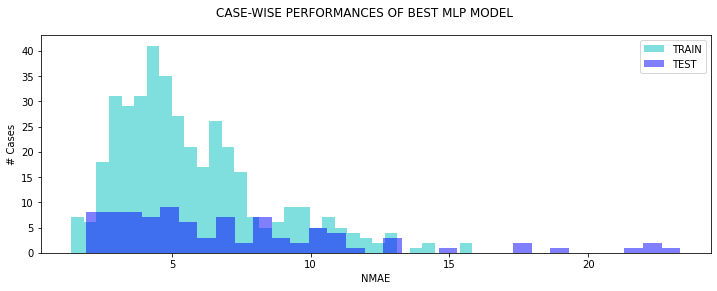

Clearly the XGB and MLP models show a better fit and generalization. All models encounter some particular hard outlier cases in the test set, which can be seen in the histgrams on the right (blue). The XGB fits the training samples a lot better, where as the MLP shows the greatest overlap in training and test cases.

----

#### Comparing Best/Worst Case Performance

Finally we can compare the performance of the models on actual cases. For this we selected the best and worst cases predicted for every model.


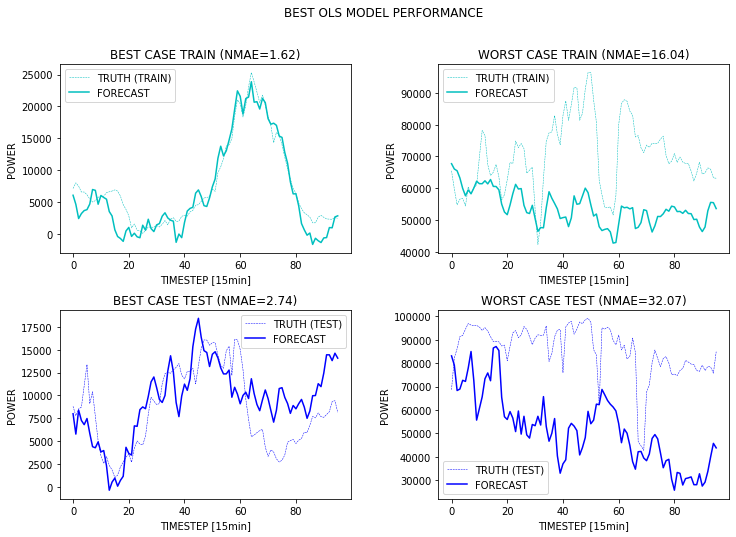

<src img="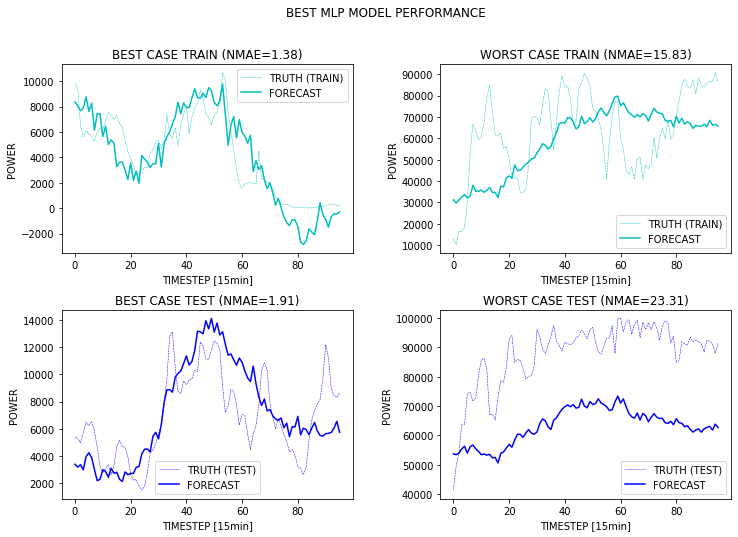">

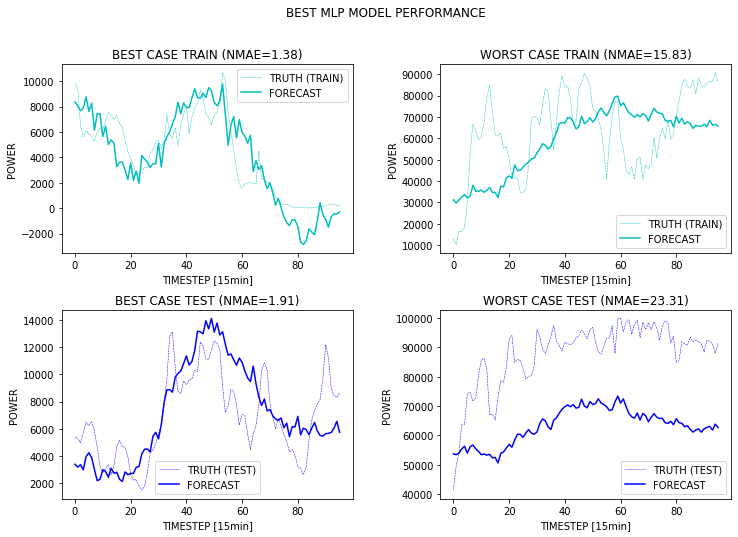

All models show good results on the training cases. Yet, the MLP arguebly shows the least bias on the edgecases. This goes in line with previously obtained results, since it does not fit the training data as closely as the XGB but generalizes better in general by catching the overall trend of the samples. The XGB and MLP model seem to have the same worst test case sample.

----

### Outlook

Where to go from here?

#### Further exploring found models

The initial random searches for the XGB and MLP models gave us a direction to look in further.<br><br>
- In case of the XGB model shallow decision trees (aka "stumps") achieve better performance in general (see hyperparameter scatter plot). Thus, I would suggest training a XGB ensemble using more trees and apply stronger regularization to prevent the overfitting already present in the currently achieved model.
- In case of the MLP model (as seen in the hyperparameter scatter plots) shallow small layered models obtain the best results. Yet, the model lacks enough capacity to fit the training data as closely as the XGB model. On the other hand deeper networks have shown worse results. But this might also be due to the more challenging training of deeper architectures. Thus, I would proceed using a deeper MLP model, employing techniques like residual layers to pass more gradient deeper into the network, while implementing tightly controlled regularization using dropout, L2 reg and batched training to avoid overfitting.

In both cases we might employ a external optimizer to tune the hyperparameters such as a Bayesian Optimizer. The XGB are faster to train, while the MLP is more costly to obtain.

----


#### Trying other models

Furthermore, I would suggest implementing some of the following approaches.

- Since the best and worst cases of the achieved models are not always the same, we could try to use a ensemble of all three models to obtain even better forecasts.
- The current XGB implementation uses a multioutputregressor as a wrapper, blocking more fine grain control of the individual XGB model's training. Therefore, one might indiviually train XGB models for every forecast timestep using forward cross-validation and different amounts of power lags (k).

----

#### Augmenting the dataset
Since the model uses a weather forecast to infer predictions it can only be as good as the achieved weather forecast. Furthermore, to explore the true physical relationships, we might use real measurements for training and employ the forecast only during prediction time. Additionally, we might obtain more training data by augmenting some parts with artificial noise. This will also result in a less overfitting model.